In [2]:
# base
import pandas as pd
import numpy as np
from scipy import sparse, stats
import warnings
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from IPython.core.display import HTML
import numpy.ma as ma # masking package
import statsmodels.api as sm
import random

# sc analysis
import scanpy.api as sc
import anndata as ad
import bbknn
import gseapy as gp

#plotting
from plotnine import *
import plotnine
import matplotlib as mp


In [5]:
# settings
print ('scanpy version: {}'.format(sc.__version__))
warnings.filterwarnings('ignore')
%matplotlib inline

# read raw data (expression data) to pandas df
pre_adata = pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/primary_mel_rawdata_181011.csv')

# read annotation data
anno = pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/primary_mel_metadata_181011.csv')

scanpy version: 1.3.2+78.g5034872


In [82]:
def gene2exp (gene_str, pd_exp):
    # Create array of transformed expression values from given gene symbol string
    # Input: str gene name + expression data in pd df
    # Outupt: linear and log10 expression arrays that can be appended to adata obj
    
    gene_names = pd_exp.iloc[:,0].tolist()
    num_obs = pd_exp.shape[1]-1
    gene_idx = [x for x,y in enumerate(gene_names) if (y in [gene_str])]
    gene_lin = pd_exp.iloc[gene_idx,1:].values.reshape((num_obs,))
    gene_log10 = np.log10(gene_lin)
    gene_log10[np.isinf(gene_log10)] = 0
    
    return gene_lin, gene_log10

def append_markers (adata, gene_markers):
    # Appends gene expression as annotation data in order to plot
    # Input: adata obj + gene list
    # Output: updated adata obj + list of passing genes
    
    try_markers = gene_markers
    for gene_name in try_markers:
        try:
            drop_obj, adata.obs[gene_name] = gene2exp(gene_name, pre_adata)
            del drop_obj
        except:
            pass

def sum_output (adata):
    # Prints cell and gene count
    # Input: ad obj
    # Output: print out
    print('\tCells: {}, Genes: {}'.format(len(adata.obs), len(adata.var_names)))

def create_adata (pre_adata):
    # Creates adata obj from raw data (rows=gene_names, col=cell_id)
    # Input: raw expression data in pd df
    # Output: adata obj
    
    print('Ingest raw data...')

    # pd df to np array
    array_adata = pre_adata.values

    # drop first column containing gene names
    array_adata = array_adata[:,1:]

    # print annotation features
    # print(list(anno)[1:])

    # extract obs and var
    obs = pre_adata.columns[1:]
    gene_names = pre_adata.iloc[:,0].tolist()
    var = pd.DataFrame()
    var['gene_symbols'] = gene_names
    
    # create ad obj
    adata = ad.AnnData(X=array_adata).T
    adata.X = sparse.csr_matrix(adata.X)
    adata.var_names = var.gene_symbols.values
    adata.var_names_make_unique()
    adata.obs_names = obs
    
    # summary
    sum_output (adata)
    
    return adata
    
def append_anno (adata, anno, anno_dict):
    # Add annotations of choice from annotation file
    # input = adata obj + dictionary of label and column name (with respect to annotation df) + anno pd df
    # output = updated adata obj
    
    print('Append annotations...')
    
    anno = anno
    anno_dict = anno_dict
    
    # append metadata of choice
    for key,value in anno_dict.items():
        adata.obs[key] = eval('anno.{}.values'.format(value))
    
    # summary
    sum_output (adata)

def remove_ercc (adata):
    # Remove ercc spike-in
    # Input: adata obj
    # Output: updated adata obj
    
    print('Remove ERCC genes...')
    
    gene_names = adata.var_names.tolist()
    ERCC_hits = list(filter(lambda x: 'ERCC' in x, gene_names))
    adata = adata[:, [x for x in gene_names if not (x in ERCC_hits)]]
    
    # summary
    print('Filtered genes: {}'.format(len(ERCC_hits)))    
    sum_output (adata)
    
    return adata

def process_adata (adata, min_counts=50000, min_genes=500, min_mean=1e-6, max_mean=1e6, min_disp=1e-6):
    # Add cell and gene filters, perform data scale/transform
    # Input: adata obj + filter options (below) + plotting option
        # min_count = int
        # min_genes = int
        # min_mean = float
        # max_mean = float
        # min_disp = float
    # Output: updated adata obj
    
    print('Process expression data...')
    print('\tInitial values:')
    sum_output(adata)
    print('min counts per cell(min_counts): {}'.format(min_counts))
    print('min genes per cell(min_genes): {}'.format(min_genes))
    print('min mean expression(min_mean): {}'.format(min_mean))
    print('max mean expression(max_mean): {}'.format(max_mean))
    print('min expression dispersion(min_disp): {}'.format(min_disp))
    
    # filter cells based on min genes and min counts cutoff
    tmp = sc.pp.filter_cells(adata, min_counts= min_counts, copy=True)
    sc.pp.filter_cells(tmp, min_genes=min_genes)

    # filter genes by dispersion
    sc.pp.filter_genes_dispersion(tmp, min_mean=min_mean, max_mean=max_mean, min_disp=min_disp)
    
    # scale and transform expression
    sc.pp.log1p(tmp)
    sc.pp.scale(tmp)
    
    # summary
    print('Filtered cells: {}'.format(len(adata.obs) - len(tmp.obs)))
    print('Filtered genes: {}'.format(len(adata.var_names) - len(tmp.var_names)))
    print('\tFinal values:')
    sum_output (tmp)
    
    return tmp

def pca_adata (adata, num_pcs=15, hoods=30):
    # Perform PCA dimensionality reduction + plot variance explained
    # Input: adata obj
    # Output: updated adata obj + print plot
    
    print('Principle component analysis...')
    
    # Perform PCA
    sc.tl.pca(adata)
    adata.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
    sc.pl.pca_variance_ratio(adata, log=True)
    
    # Neigbhor graph
    print('Enter number of principle components to use:')
    input1 = input()
    try:
        num_pcs = int(input1)
    except Exception as e:
        print(e)
        print('Using default settings')
    
    print('principle_components(num_pcs): {}\ncells/neighborhood(hoods): {}'.format(num_pcs, hoods))
    sc.pp.neighbors(adata,n_pcs=num_pcs, n_neighbors=hoods)

def umap_adata (adata, meta_labels=None, res=0.5):
    # Perform clustering and UMAP
    # Input: adata obj + cluster options (below)
        # num_pcs = number of principle components
        # hoods = number of cells in neighborhood
        # res = resolution of community detection
    # Output: updated adata + UMAP to std out
    
    print('Uniform manifold approximation and projection...')
    
    # sample resolutions for louvain clustering
    print('\tScan Louvain detection resolutions')
    scan_res(adata) 

    print('Enter Louvain detection resolution to use:')
    input1 = input()
    try:
        res = float(input1)
    except Exception as e:
        print(e)
        print('Using default settings')
    
    print('resolution(res): {}'.format(res))
    
    # UAMP: Uniform Maniford Approximation and Projection
    sc.tl.umap(adata)

    # Louvain community clustering
    sc.tl.louvain(adata, resolution = res)
    sc.pl.umap(adata, color=meta_labels, legend_loc='on data')
    
    # Plot metadata
    if meta_labels is None:
        meta_labels = sorted([x for x in adata.obs.columns.values.tolist() if (x is not 'louvain')])
        sc.pl.umap(adata, color=meta_labels)
    else:
        pass
    
def subset_adata (raw_adata, feature_dict):
    # Subset adata obj by user dictionary of features and values list. Filter operation below:
        # level1: value1 | value2 | value3...
        # level2: key1 & key2 & key3...
    # Input: raw_adata obj + dictionary of feature:[value1, value2...]
    # Output: subsetted adata obj
    
    input_adata = raw_adata
    stack_len = len(input_adata.obs)
    subset_arr = np.zeros((len(feature_dict), stack_len))
    
    print('Subsetting data...See stdout to check that filter criteria return matches!')
    print('Input cells = {}'.format(stack_len))
    
    key_count = 0
    for key,value in feature_dict.items(): 
        depth = 0
        stack_depth = len(value)
        stack = np.empty((stack_depth, stack_len))
        for val in value:
            stack[depth, :] = np.array(input_adata.obs[key] == val, dtype='bool')
            print('key = {}, value = {}, matched = {}'.format(key,val,np.sum(stack[depth, :], dtype='int')))
            depth += 1    
        subset_value = np.sum(stack, axis = 0, dtype='bool')
        subset_arr[key_count, :] = subset_value
        key_count += 1
        
    subset_list = np.product(subset_arr, axis = 0, dtype='bool')    
    input_adata = input_adata[subset_list,:]
    print('Remaining cells = {}'.format(len(input_adata.obs)))
    print('Subsetting complete')
    
    return input_adata

def class2continuous_reg (X, y, test_size = 0.33):
    # Linear regression and returns R2
    # Input: list/array of predictors (categorical = str) and list of responses (float)
    # Output: R2 value
    
    pred = X # must be categorical
    res = y # must be continuous
    factor_levels = np.unique(pred)
    factor_len = len(factor_levels)

    df = pd.DataFrame({'pred':pred})
    df = pd.get_dummies(df)
    df['res'] = res

    X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:factor_len]],df[df.columns[factor_len]],test_size=test_size, random_state=42)

    lm = LinearRegression()
    lm.fit(X=X_train, y=y_train)
    
    return lm.score(X=X_test, y=y_test)

def class2class_reg (X, y, test_size=0.33):
    # Logistic regression and returns accuracy
    # Input: list/array of predictors (categorical = str) and list of responses (categorical = str)
    # Output: accuracy value

    pred = X # must be categorical
    res = y # must be categorical
    factor_levels = np.unique(pred)
    factor_len = len(factor_levels)
    
    if len(np.unique(res)) == 1:
        acc = 0
    else:

        df = pd.DataFrame({'pred':pred})
        df = pd.get_dummies(df)
        df['res'] = res

        X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:factor_len]],df[df.columns[factor_len]],test_size=test_size, random_state=42)

        # accurcy
        clf = LogisticRegression(multi_class='auto')
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test)
        y_pred = clf.predict(X_test)

        # try label-sized adjusted f1 score
        from sklearn.metrics import f1_score
        acc  = f1_score(y_pred=y_pred, y_true=y_test,average='weighted')
    
    # psuedo R2
#     logit = sm.MNLogit(y_train, X_train)
#     result = logit.fit()
#     summ_df = pd.read_html(result.summary().tables[0].as_html())[0]
#     pseudo_r2 = summ_df.iloc[3,3]
    
    return acc #, pseudo_r2

def scan_res(input_adata, step_size=0.05):
    # Scan through resolution setting for Louvain clustering and return similarity to previous step. Used to determine resolution setting.
    # Input: ad obj + step size (optional; float)
    # Output: print plot
    
    print('\tresolution_interval(step_size): {}'.format(step_size))
    
    basis_point = int(step_size * 100)
    
    # compute clusters
    df = pd.DataFrame()
    res_list = [x/100 for x in range(basis_point,100,basis_point)]
    for res in res_list:
        tmp = input_adata
        sc.tl.louvain(tmp, resolution = res)
        df['res_{}'.format(res)] = tmp.obs['louvain']
    
    # compute log reg
    col_labels = df.columns.tolist()
    acc_list = []
    for idx in range(len(col_labels)-1):
        acc_list.append(class2class_reg(X=df[col_labels[idx]].values, y=df[col_labels[idx+1]].values))

    sim_df = pd.DataFrame({'resolution':res_list[1:],
                          'similarity':acc_list})
    
    plotnine.options.figure_size = (2,2)

    print(ggplot(sim_df, aes(x='resolution',y='similarity'))+
        theme_bw()+
         theme(aspect_ratio=1)+
         geom_line())

# Ingest data protocol
- Raw data and annotation CSV provided by Ashley Maynard
- Created new classifier of Mel vs Krt cells based on log10 enrichment ratio of PMEL / KRT5. Specifically, abs(z-score) > 1 is the decision boundary.
- Subsequently, ERCC-associated gene names are removed.

In [75]:
raw_adata = create_adata(pre_adata)
anno_dict = {'age':'age',
             'plate':'plate',
             'location':'Anatomical_location',
             'race':'Race',
             'sex':'Sex',
             'color':'sample_color',
             'patient':'patient_id'}
append_anno(raw_adata, anno, anno_dict)
append_markers(raw_adata, ['PMEL','KRT1','KRT5','KRT10','TYR','MITF'])
raw_adata = remove_ercc(raw_adata) 

Ingest raw data...
	Cells: 4356, Genes: 26485
Append annotations...
	Cells: 4356, Genes: 26485
Remove ERCC genes...
Filtered genes: 11
	Cells: 4356, Genes: 26474


# Cohort analysis
- Determine general statistics
- Determine feature class statistics

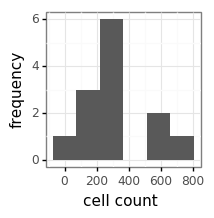

<ggplot: (8755898865896)>


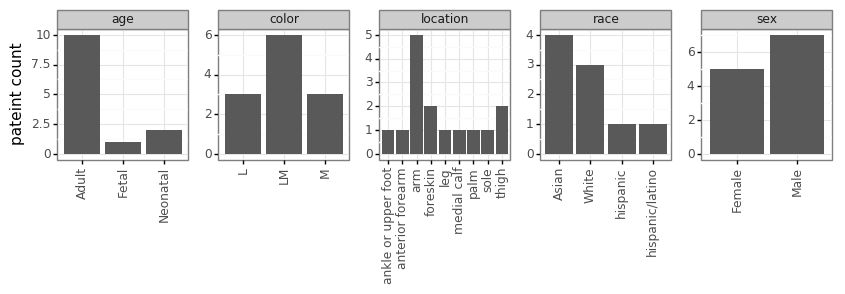

<ggplot: (8755867019563)>


In [76]:
input_data = raw_adata

# Cell distribution among patients
plot_data = list(input_data.obs.groupby('patient').count()['plate'])
df = pd.DataFrame({'counts':plot_data})

plotnine.options.figure_size = (2,2)
print(ggplot(df, aes(x='counts'))+
     theme_bw() +
     theme(aspect_ratio=1)+
    geom_histogram()+
    labs(x='cell count', y='frequency'))

# Patient distribution among classes
count_list = []
label_list = []
group_list = []
for feat in ['age','color','sex','race','location']:
    count_list = count_list + input_data.obs.groupby(by=feat).nunique()['patient'].values.tolist()
    labels = input_data.obs.groupby(by=feat).nunique().index.tolist()
    label_list = label_list + labels
    group_list = group_list + [feat for x in range(len(labels))]
df = pd.DataFrame({'group':group_list,'key':label_list,'count':count_list})

plotnine.options.figure_size = (10, 10)
print(ggplot(df, aes('key','count'))+
     theme_bw() +
     theme(aspect_ratio=1,
          axis_text_x=element_text(angle=90),
          panel_spacing_x=0.3) +
    geom_bar(stat='identity', position='dodge') +
    facet_wrap('~group', scales='free', nrow = 1) +
    labs(y='pateint count', x=''))

# All-cells analysis
- Filter cells/genes: min-reads, min-genes, and dispersion range
- Scale/transform expression values
- PCA dimensionality reduction
- Cluster by diffusion-like random walk
- Louvain community detection
- UMAP plot

Process expression data...
	Initial values:
	Cells: 4356, Genes: 26474
min counts per cell(min_counts): 50000
min genes per cell(min_genes): 500
min mean expression(min_mean): 1e-12
max mean expression(max_mean): 1000000000000.0
min expression dispersion(min_disp): 0.1
Filtered cells: 45
Filtered genes: 15764
	Final values:
	Cells: 4311, Genes: 10710
Principle component analysis...


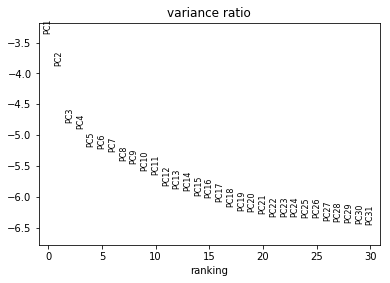

Enter number of principle components to use:
20
principle_components(num_pcs): 20
cells/neighborhood(hoods): 30
Uniform manifold approximation and projection...
	Scan Louvain detection resolutions
	resolution_interval(step_size): 0.05


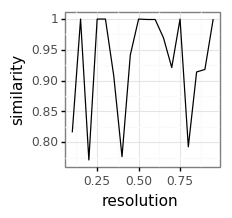

<ggplot: (8755898222102)>
Enter Louvain detection resolution to use:
0.8
resolution(res): 0.8
... storing 'age' as categorical
... storing 'plate' as categorical
... storing 'location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical


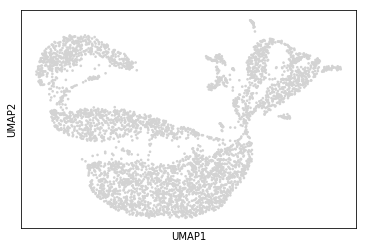

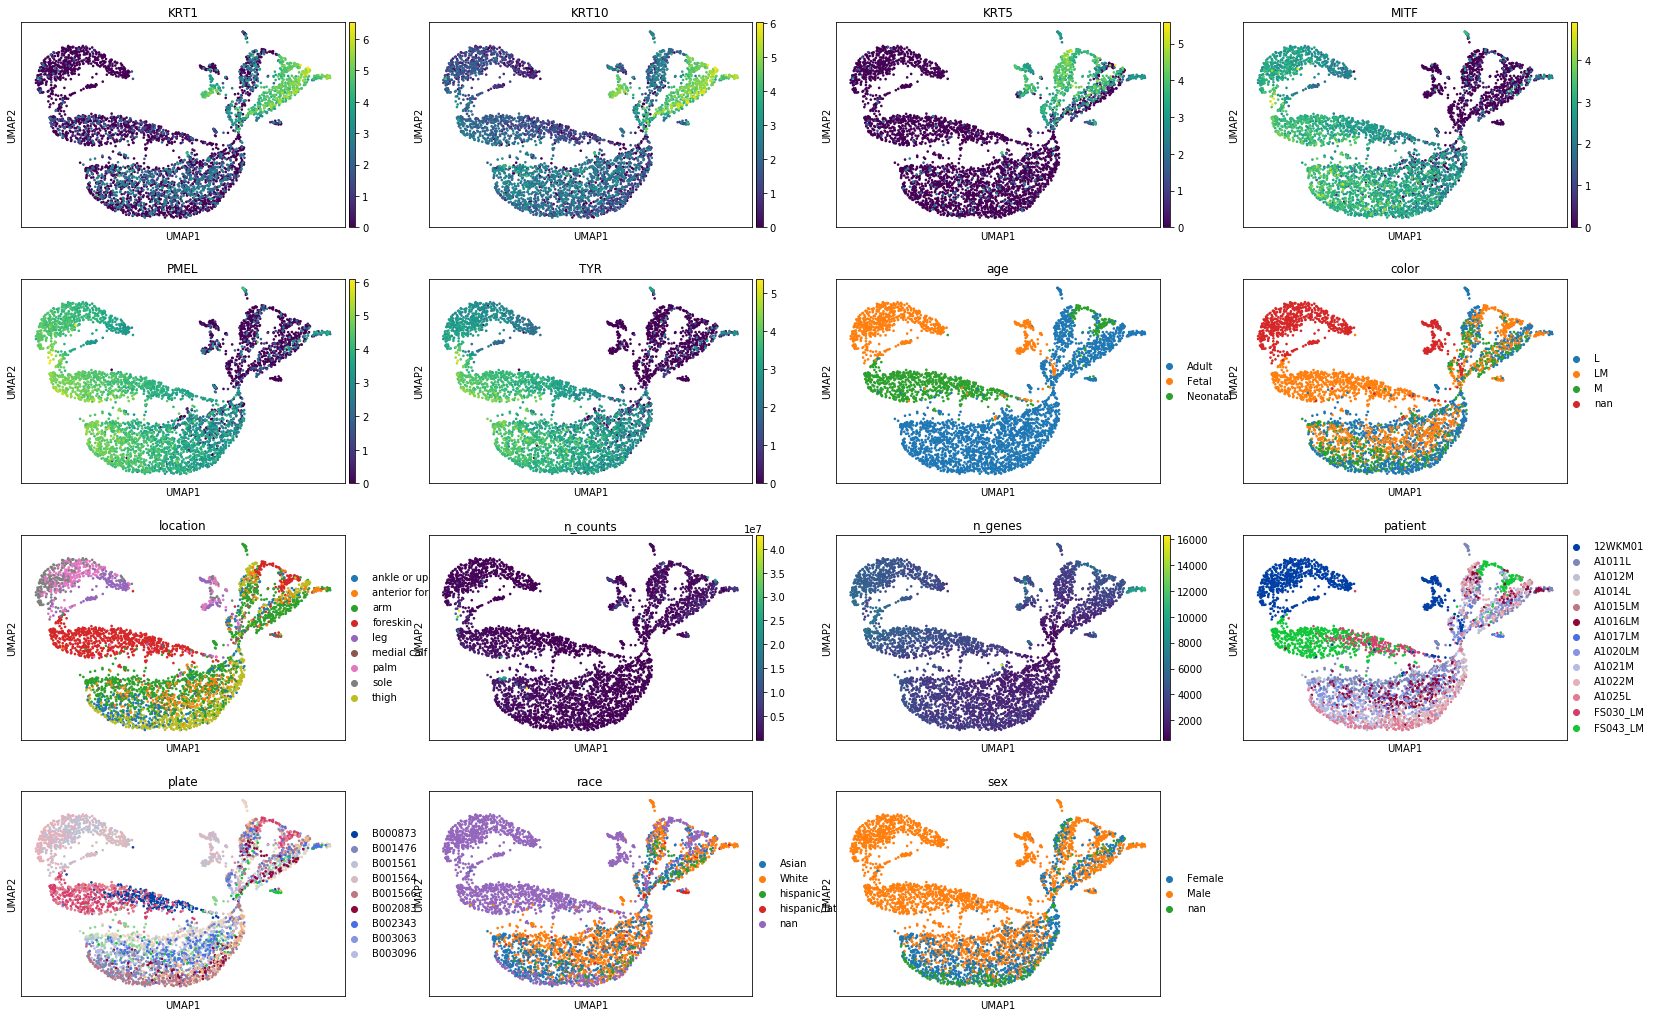

In [83]:
full_adata = process_adata(raw_adata, min_mean=1e-12, max_mean=1e12, min_disp=0.1)
pca_adata(full_adata)
umap_adata(full_adata)

In [78]:
target = 'PMEL'
if target in raw_adata.var_names.tolist():
    print('full_yes')

if target in full_adata.var_names.tolist():
    print('subset_yes')

full_yes


In [74]:
full_adata


AnnData object with n_obs × n_vars = 4311 × 9925 
    obs: 'age', 'plate', 'location', 'race', 'sex', 'color', 'patient', 'PMEL', 'KRT1', 'KRT5', 'KRT10', 'TYR', 'n_counts', 'n_genes', 'louvain'
    var: 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'louvain', 'age_colors', 'color_colors', 'location_colors', 'louvain_colors', 'patient_colors', 'plate_colors', 'race_colors', 'sex_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

# Subset and re-analyze
- Subset filter based on categorical clinical metadata and assigned cluster: age, location, race, sex, ratio_label, color, patient, louvain

In [ ]:
feature_dict = {'ratio_label':['MEL'], 'age':['Adult']}
adata_subset = subset_adata(raw_adata, feature_dict)
adata_subset = process_adata(adata_subset)
adata_subset = pca_adata(adata_subset)
scan_res(adata_subset) # sample resolutions for louvain clustering
adata_subset = umap_adata(adata_subset, meta_labels=['louvain','HRH2','KRT1','PMEL','KRT10','KRT5'], res=0.3)

# Quantify class covariance
- High degree of covariation indicates dependent classes

In [ ]:
# correlation among features
input_data = adata_subset

fltrd_labels = [key for key,value in anno_dict.items()] + ['louvain']
df = pd.DataFrame()   
for label_col in fltrd_labels:
    acc_list = []
    for label_row in fltrd_labels:
        acc_list.append(class2class_reg(X=input_data.obs[label_row], y=input_data.obs[label_col]))
    df['{}'.format(label_col)] = acc_list
df['predictor'] = fltrd_labels
# print(df)

plotnine.options.figure_size = (3,3)
plot_df = pd.melt(df, id_vars=['predictor'])
(ggplot(plot_df, aes('variable','predictor',fill='value')) +
     theme_bw() +
     theme(aspect_ratio=1,
          axis_text_x=element_text(angle=90)) +
     geom_tile() +
     labs(x='response', y='predictor', fill='F1-score')+
    scale_fill_cmap(name='afmhot'))

***
# DEV

In [ ]:
# Return top-ranked genes per louvain cluster

tmp = adata_subset

sc.tl.rank_genes_groups(tmp, 'louvain', method='logreg')
sc.pl.rank_genes_groups(tmp, n_genes=20, sharey=False)
pd.DataFrame(tmp.uns['rank_genes_groups']['names']).head(10)

In [ ]:
# Rank genes from subsetted data

sc.tl.rank_genes_groups(adult_mel_subset, 'louvain', method='logreg')
sc.pl.rank_genes_groups(adult_mel_subset, n_genes=20, sharey=False)
print(pd.DataFrame(adult_mel_subset.uns['rank_genes_groups']['names']).head(10))

pd.DataFrame(adult_mel_subset.uns['rank_genes_groups']['names']).head(10)['1']

# Perform gene set enrichment analysis
glist = pd.DataFrame(adult_mel_subset.uns['rank_genes_groups']['names']).head(10)['1'].squeeze().tolist()

enr = gp.enrichr(gene_list = glist,
                description='test',
                gene_sets=['GO_Biological_Process_2018'],
                outdir='/home/ubuntu/data/enrichr_kegg',
                cutoff=0.5)

print(enr.res2d.head(10))

# Gene set enrichment and pathway analysis
- Implemented Enrichr (based on Fisher's Exact test) to determine gene ontology using the top 5% of enriched genes.

In [ ]:

for val in ['Adult','Neonatal','Fetal']:
    # Rank genes
    print('\nKey = {}'.format(val))
    idx_bool = (adata.obs['age'] == val)
    idx_bool = list(idx_bool.values)
    idx = [x for x,y in enumerate(idx_bool) if y == True]
    adata_tmp = adata[idx,:]
    sc.tl.rank_genes_groups(adata_tmp, 'ratio_label', method='logreg')
    sc.pl.rank_genes_groups(adata_tmp, n_genes=20, sharey=False)
    print(pd.DataFrame(adata_tmp.uns['rank_genes_groups']['names']).head(10))
    
    # GO term
    for cell in ['KRT', 'MEL']:
        print('\nCell = {}'.format(cell))
        glist = pd.DataFrame(adata_tmp.uns['rank_genes_groups']['names']).head(int(len(adata.var)*0.05))[cell].squeeze().tolist()

        enr = gp.enrichr(gene_list = glist,
                        description='test',
                        gene_sets=['GO_Biological_Process_2018'],
                        outdir='/home/ubuntu/data/enrichr_kegg',
                        cutoff=0.5)

        print(enr.res2d.head(10))

In [ ]:
# PCA compared to metadata

### double check about number of each class == looks like some classes only show up a few times depending on PC combo

input_data = adata
meta_name = 'age'
var_explained = input_data.uns['pca']['variance_ratio'] # extract variance explained by each PC axis

for pcval in range(len(var_explained)-1):
    PC1 = pcval
    PC2 = PC1+1

    pcX = input_data.obsm['X_pca'][:,PC1]
    pcY = input_data.obsm['X_pca'][:,PC2]
    meta_val = input_data.obs[meta_name]

    plot_df = pd.DataFrame({'PC{}'.format(PC1):[np.log10(x) for x in pcX], 
                            'PC{}'.format(PC2):[np.log10(x) for x in pcY],
                            'age':meta_val})

    print((ggplot(plot_df) +
        theme_bw() +
        theme(aspect_ratio = 1) +
        geom_point(aes('PC{}'.format(PC1), 'PC{}'.format(PC2), color = 'age'), alpha = 0.2)))

In [ ]:
# GSEA from PCA gene sets


print('obs x PCs = {}'.format(adult_mel_subset.obsm['X_pca'].shape)) # observations x PCs = matrix U = rotated (transposed) original data
print('var x PCs = {}'.format(adult_mel_subset.varm['PCs'].shape)) # variables x PCs = matrix V = weights of each variable in PC

# adult_mel_subset.varm['PCs'][1,:50] # first idx = variable (gene); second idx = vector of PCs factor loadings
                                    # the squared factor loading  = Pearson's R2
gene_names = adult_mel_subset.var_names.tolist()
var_PC = adult_mel_subset.varm['PCs']
# for PC in range(var_PC.shape[1]):
for PC in range(var_PC.shape[1]):
    print('\nPC{}\n'.format(PC))
    weight_list = var_PC[:,PC].tolist()
    corr_list = [(x**2) for x in weight_list]
    corr_df = pd.DataFrame([gene_names, corr_list]).T
    qtile = corr_df.iloc[:,1].quantile(0.99)
    top_rows = corr_df.iloc[:,1].values > qtile
    top_df = corr_df.iloc[top_rows,:]
    top_df = top_df.reset_index(drop=True)
    top_df = top_df.sort_values(by=[1], ascending=False)
    
    glist = top_df.iloc[:,0].squeeze().tolist()
    enr = gp.enrichr(gene_list = glist,
                    description='test',
                    gene_sets=['GO_Biological_Process_2018'],
                    outdir='/home/ubuntu/data/enrichr_kegg',
                    cutoff=0.5)
    print(enr.res2d.iloc[:10,[0,3]])
    
    

In [ ]:
# read-in gene set list
## ref: http://software.broadinstitute.org/gsea/msigdb/cards/GO_RESPONSE_TO_CALCIUM_ION.html
Ca_df = pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/ca_list.txt', skiprows=2, header=None)
Ca_list = Ca_df.iloc[:,0].values.tolist()

## ref: http://software.broadinstitute.org/gsea/msigdb/cards/KEGG_CALCIUM_SIGNALING_PATHWAY.html
Ca_df2 = pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/ca_kegg.txt', skiprows=2, header=None)
Ca_list2 = Ca_df2.iloc[:,0].values.tolist()

## ref: http://software.broadinstitute.org/gsea/msigdb/cards/GO_RESPONSE_TO_ACETYLCHOLINE.html
ACh_df = pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/ACh_list.txt', skiprows=2, header=None)
ACh_list = ACh_df.iloc[:,0].values.tolist()

## ref: http://software.broadinstitute.org/gsea/msigdb/cards/GO_ACETYLCHOLINE_RECEPTOR_ACTIVITY.html
ACh_df2 = pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/ACh_receptlist.txt', skiprows=2, header=None)
ACh_list2 = ACh_df2.iloc[:,0].values.tolist()

## ref: http://software.broadinstitute.org/gsea/msigdb/cards/GO_SCHWANN_CELL_DIFFERENTIATION.html
SC_df = pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/schwann_list.txt', skiprows=2, header=None)
SC_list = SC_df.iloc[:,0].values.tolist()

## ref: http://software.broadinstitute.org/gsea/msigdb/cards/GO_SCHWANN_CELL_DEVELOPMENT.html
SC_df2 = pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/sch_devlist.txt', skiprows=2, header=None)
SC_list2 = SC_df2.iloc[:,0].values.tolist()

gene_markers = Ca_list + Ca_list2 + ACh_list + ACh_list2 + SC_list + SC_list2


    # check for schwann cell markers
    
        ### TFs and surface markers after subsetting age groups

    ## SOX10, S100, OCT6, NCAM, GAP43 are SC marker: https://www.ncbi.nlm.nih.gov/pubmed/25859851
    ## NRG1 induces SOX10 expression: https://www.sciencedirect.com/science/article/pii/S2213671117301650
    ## FOXD3,SOX2,MITF implecated in SC differentiation into melanoblasts: http://cshperspectives.cshlp.org/content/7/7/a020487.full
    ## ZIC1, PAX3, SNAIL2, SOX9 http://dev.biologists.org/content/142/4/620
    ## TRPM in Ca2+: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2740396/
#     try_markers = ['KRT1','KRT10','TP63','TRPM1','MCOLN1','MCOLN2','MCOLN3','GAP43','NCAM','OCT6','S100','SOX10','NRG1',
#                    'FOXD3','SOX2','MITF','SOX9','SNAIL2', 'ZIC1', 'PAX3',
#                   'P75NTR','MBP','MPZ','DHH','PTEN','TP53','TGFB1',
#                   'NOTCH1','NOTCH2','BCL2','ERBB1','ERBB2','ERBB3','ERBB4',
#                   'ITGAV','ITGB3','ITGA6','ITGB4','EGF','EGFR','MAPK3',
#                   'ERK1','MAPK1','ERK2','AKT1','CHRNA1','CHRNA2','CHRNA13','CHRNA4','CHRNA5','CHRNA6','CHRNA7',
#                   'CHRNA8','CHRNA9','CHRNA10','CHRNB1','CHRNB2','CHRNB3','CHRNB4','CHRND','CHRNE','CHRNG',
#                   'LYPD1','PVALB','POSTN','LRP2','CCL3','IFI27','ROPN1','AKAP110','CABYR'] 